In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import stats
import re
from scipy.stats import pearsonr,spearmanr,fisher_exact,binom_test
#import rpy2.robjects as robjects
import random
from statsmodels.stats.multitest import fdrcorrection
import os
import seaborn as sns
#import gseapy as gs
from scipy.stats import norm
import gseapy as gs
from collections import Counter
import scanpy as sc

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Colors
mouse = "#F2C911"
rat = "#65B0AC"
intrinsic = "#F55F00"
extrinsic = "#7D9AF4"
reinforcing = "#9B00F5"
opposing = "#F50901"
interaction = "#1E771A"

sns.set(font_scale=1.5)
sns.set_style("white")
d_ct_abrev = {"chondrocytes":"chondrocyte", "Chondrocyte":"chondrocyte", "Forebrain glutamatergic progenitors":"brain.glut.prog", "Forebrain GABAergic progenitors":"brain.GABA.prog", "Intermediate progenitors":"inter.prog", "Forebrain glutamatergic neurons":"brain.glut.neu", "Forebrain GABAergic neurons":"brain.GABA.neu", "Spinal GABAergic neurons":"spine.GABA.neu", "Spinal glutamatergic neurons":"spine.glut.neu", "Chondrocytes":"chondrocyte", "Mesenchyme 0":"mesen.0", "Mesenchyme 2":"mesen.2", "Mesenchyme cycling":"mesen.cyc", "Forebrain GABAergic neurons 0":"Toss"}

def file_to_celltype(x):
    x = x.split("/")[-1]
    x = x.replace("_GO_Molecular_Function_2023", "").replace("_GO_Biological_Process_2023", "").replace("Mesechyme", "Mesenchyme").replace("Brain_Or_2010_Div_New4_NewNorm_", "")
    x = x.replace("Mesenchymal_Or_2010_Div_New4_NewNorm_", "").replace("Chondrocyte_Or_2010_Div_New4_NewNorm_", "").replace(".csv", "").replace("_", " ").replace(" all", "")
    x = x.replace("Glutamatergic", "Forebrain glutamatergic").replace("GABAergic", "Forebrain GABAergic").replace("Spinal Forebrain", "Spinal").replace("Chondrocytes", "Chondrocyte")
    return x

plt.rcParams["font.family"] = "Arial"

def summarize_enrichment(fold, out_file):
    #Summarize the enrichments
    out = []
    for folder in os.listdir("Final/" + fold):
        v = pd.read_csv("Final/" + fold + "/" + folder + "/" + "gseapy.gene_set.prerank.report.csv")
        for index, row in v.iterrows():
            if row["FDR q-val"] < 0.25:
                out.append([folder, row["Term"], row["FDR q-val"], row["NES"], row["Lead_genes"]])

    df = pd.DataFrame(out)
    df.columns = ["Cluster_Category", "Term", "FDR", "NES", "Ledge genes"]
    df = df.sort_values("FDR")
    df.to_csv("Final/Summarized_Enrichments_" + out_file + ".csv", index = False)

In [3]:
imp_conf_list = []
o = open("mouse_imprinted_genes.txt")
for line in o:
    l = line.replace("\xa0", "").replace("\n", "").split("\t")
    if ("Imprinted" in l[3] or "Predicted" in l[3]) and "Not" not in l[3]:
        imp_conf_list.append(l)
df_imp_info = pd.DataFrame(imp_conf_list)
df_imp_info

,0,1,2,3,4
0,Zdbf2,"""4930431J08Rik, 9330107J05Rik, RP23-434D24.2""",1,Imprinted,Paternal
1,Gpr1,,1AS,Imprinted,Paternal
2,Mir298,"""Mirn298, mmu-mir-298""",2AS,Imprinted,Paternal
3,Mcts2,"""PSIMCT-1, RP23-35I8.12, 2400002F11Rik""",2,Imprinted,Paternal
4,Mir296,"""Mirn296, mmu-mir-296""",2AS,Imprinted,Paternal
...,...,...,...,...,...
147,Tsix,antisense of Xist,X 42.0 cM,Imprinted,Maternal
148,Jpx,"""Enox, 2010000I03Rik, 2510040I06Rik""",X 46.17 cM,Imprinted,Paternal
149,Ftx,"""Thcytx, BB219131, NCRNA00182, B230206F22Rik""",X 46.21 cMAS,Imprinted,Paternal
150,Zcchc13,"""Cnbp2, 4930513O09Rik""",X 46.26 cM,Imprinted,Maternal


In [4]:
d_imp = {"Imprinted":list(df_imp_info[0])}

In [20]:
df = pd.DataFrame()
ind = 1
keep = "Brain"
divergence = "Interaction"
rank = True
for file in os.listdir("Final/Div"):
    if keep == "All":
        v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
        v["Abs " + divergence.lower()] = np.abs(v[divergence])
        v = v[["Abs " + divergence.lower()]]
        v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
        if ind:
            df = v
            ind = 0
        else:
            df = df.join(v, how="outer")
    else:
        if keep == "Brain":
            if "Brain" in file:
                v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
                v["Abs " + divergence.lower()] = np.abs(v[divergence])
                v = v[["Abs " + divergence.lower()]]
                v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
                if ind:
                    df = v
                    ind = 0
                else:
                    df = df.join(v, how="outer")
        elif keep == "Conn":
            if "Brain" not in file:
                v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
                v["Abs " + divergence.lower()] = np.abs(v[divergence])
                v = v[["Abs " + divergence.lower()]]
                v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
                if ind:
                    df = v
                    ind = 0
                else:
                    df = df.join(v, how="outer")
out = []
indices = []
for index, row in df.iterrows():
    if keep == "All":
        if len(row.dropna()) > 4:
            out.append(np.mean(row.dropna()))
            indices.append(index)
    else:
        if len(row.dropna()) > 2:
            out.append(np.mean(row.dropna()))
            indices.append(index)
df2 = pd.DataFrame(out)
df2.index = indices
df2.columns = ["Abs " + divergence.lower()]
df2 = df2.sort_values("Abs " + divergence.lower(), ascending = False)
df2["Gene"] = df2.index
ranking = df2[["Gene", "Abs interaction"]]
if rank:
    front_half = list(range(1, ranking.shape[0]//2+1))
    front_half.sort(reverse=True)
    back_half = [-x for x in range(1, ranking.shape[0]//2+1)]
    if ranking.shape[0] % 2 == 0:
        ranking["Abs interaction"] = front_half + back_half
    else:
        ranking["Abs interaction"] = front_half + [0] + back_half
#gs.prerank(rnk=ranking, gene_sets=d_imp, threads=4, permutation_num=1000, outdir= 'C:/Users/astar/Chimerism/Final/GSEAPY_New4_Imprinting_Rank/' + keep + "_" + "Imprinting", format='png', seed=6, min_size = 10, max_size = 300)

In [5]:
d_imp2 = {"Paternal":list(df_imp_info[df_imp_info[4].isin(["Paternal"])][0]), "Maternal":list(df_imp_info[df_imp_info[4].isin(["Maternal"])][0])}


In [35]:
df = pd.DataFrame()
ind = 1
keep = "Brain"
divergence = "Interaction"
rank = False
for file in os.listdir("Final/Div"):
    if keep == "All":
        v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
        v = v[[divergence]]
        v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
        if ind:
            df = v
            ind = 0
        else:
            df = df.join(v, how="outer")
    else:
        if keep == "Brain":
            if "Brain" in file:
                v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
                v = v[[divergence]]
                v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
                if ind:
                    df = v
                    ind = 0
                else:
                    df = df.join(v, how="outer")
        elif keep == "Conn":
            if "Brain" not in file:
                v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
                v = v[[divergence]]
                v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
                if ind:
                    df = v
                    ind = 0
                else:
                    df = df.join(v, how="outer")
out = []
indices = []
for index, row in df.iterrows():
    if keep == "All":
        if len(row.dropna()) > 4:
            out.append(np.mean(row.dropna()))
            indices.append(index)
    else:
        if len(row.dropna()) > 2:
            out.append(np.mean(row.dropna()))
            indices.append(index)
df2 = pd.DataFrame(out)
df2.index = indices
df2.columns = [divergence]
df2 = df2.sort_values(divergence, ascending = False)
df2["Gene"] = df2.index
ranking = df2[["Gene", divergence]]
if rank:
    front_half = list(range(1, ranking.shape[0]//2+1))
    front_half.sort(reverse=True)
    back_half = [-x for x in range(1, ranking.shape[0]//2+1)]
    if ranking.shape[0] % 2 == 0:
        ranking["Abs interaction"] = front_half + back_half
    else:
        ranking["Abs interaction"] = front_half + [0] + back_half
gs.prerank(rnk=ranking, gene_sets=d_imp2, threads=4, permutation_num=1000, outdir= 'C:/Users/astar/Chimerism/Final/GSEAPY_New4_Imprinting_Signed/' + keep + "_" + "Imprinting_PatMat", format='png', seed=6, min_size = 10, max_size = 300)

In [7]:
#Repeat for DR/HR to match the embryonic heart data, not used
df = pd.DataFrame()
ind = 1
keep = "Conn"
divergence = "DR/HR"
rank = False
for file in os.listdir("Final/Div"):
    if keep == "All":
        v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
        v = v[[divergence]]
        v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
        if ind:
            df = v
            ind = 0
        else:
            df = df.join(v, how="outer")
    else:
        if keep == "Brain":
            if "Brain" in file:
                v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
                v = v[[divergence]]
                v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
                if ind:
                    df = v
                    ind = 0
                else:
                    df = df.join(v, how="outer")
        elif keep == "Conn":
            if "Brain" not in file:
                v = pd.read_csv("Final/Div/" + file).set_index("Unnamed: 0")
                v = v[[divergence]]
                v.columns = [d_ct_abrev[file_to_celltype(file)].replace(".", "_")]
                if ind:
                    df = v
                    ind = 0
                else:
                    df = df.join(v, how="outer")
out = []
indices = []
for index, row in df.iterrows():
    if keep == "All":
        if len(row.dropna()) > 4:
            out.append(np.mean(row.dropna()))
            indices.append(index)
    else:
        if len(row.dropna()) > 2:
            out.append(np.mean(row.dropna()))
            indices.append(index)
df2 = pd.DataFrame(out)
df2.index = indices
df2.columns = [divergence]
df2 = df2.sort_values(divergence, ascending = False)
df2["Gene"] = df2.index
ranking = df2[["Gene", divergence]]
if rank:
    front_half = list(range(1, ranking.shape[0]//2+1))
    front_half.sort(reverse=True)
    back_half = [-x for x in range(1, ranking.shape[0]//2+1)]
    if ranking.shape[0] % 2 == 0:
        ranking["Abs interaction"] = front_half + back_half
    else:
        ranking["Abs interaction"] = front_half + [0] + back_half
gs.prerank(rnk=ranking, gene_sets=d_imp2, threads=4, permutation_num=1000, outdir= 'C:/Users/astar/Chimerism/Final/GSEAPY_New4_Imprinting_Signed/' + keep + "_" + "Imprinting_PatMat_HRDR", format='png', seed=6, min_size = 10, max_size = 300)

2024-04-21 11:36:37,049 [WARNING] Duplicated values found in preranked stats: 0.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


<Axes: xlabel='DR/HR', ylabel='DM/HM'>

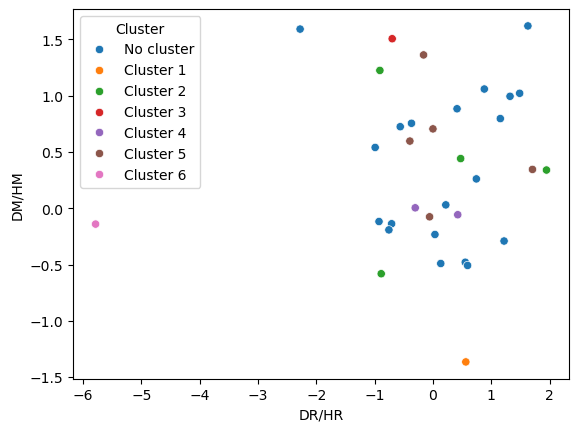

In [69]:
#Plot different clusters (in the genome) of imprinted genes

file = "Brain_Or_2010_Div_New4_NewNorm_GABAergic_progenitors.csv"
v = pd.read_csv("Final/Div/" + file, sep = ",").set_index("Unnamed: 0")
#vv = pd.read_csv("Final/NoDiv/" + file.replace("Div", "NoDiv"), sep = ",").set_index("Unnamed: 0")
#v = pd.concat([v, vv])
df_imp_info.index = df_imp_info[0]
v_imp = v.join(df_imp_info).dropna()

c1 = ["Blcap, Nnat", "Zfp64"]
c2 = ["Peg10", "Sgce", "Ppp1r9a", "Asb4"]
c3 = ["Ndn", "Magel2"]
c4 = ["Peg3", "Zim1", "Usp29"]
c5 = ["Cd81", "Tssc4", "Kcnq1", "Cdkn1c", "Phlda2", "Nap1l4"]
c6 = ["Grb10", "Ddc"]
add_on = []
for index, row in v_imp.iterrows():
    if index in c1:
        add_on.append("Cluster 1")
    elif index in c2:
        add_on.append("Cluster 2")
    elif index in c3:
        add_on.append("Cluster 3")
    elif index in c4:
        add_on.append("Cluster 4")
    elif index in c5:
        add_on.append("Cluster 5")
    elif index in c6:
        add_on.append("Cluster 6")
    else:
        add_on.append("No cluster")
v_imp["Cluster"] = add_on
sns.scatterplot(data=v_imp, x="DR/HR", y = "DM/HM", hue = "Cluster")